# Analyse Oyster Card data
- read in one month of Oyster card data
- convert raw data into useful metrics
- present the data
- learn about PANDAS along the way

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
journeys = pd.read_csv("oyster-card-Nov2018.csv")

### Describe the data frame we've just loaded


In [2]:
# # describe contents of the data frame.
#  print(journeys.shape) # prints a touple of rows x columns
print(journeys.columns)
# print('There are ',len(journeys.columns), 'colums', 'and ',journeys.count())
# journeys.info() # detailed info on fram
# journeys.dtypes # list data types of each column
# journeys.describe() # print stats about our data frame

print(journeys['Start Time'].count()) # journeys that have a start time Bus & Tube
print(journeys['End Time'].count()) # journeys that have an end time Tube but not bus.

journeys['Journey/Action'].value_counts()
# show a grouped by count of all the different actions

journeys['Date'].unique().tolist()

Index(['Date', 'Start Time', 'End Time', 'Journey/Action', 'Charge', 'Credit',
       'Balance', 'Note'],
      dtype='object')
77
45


['30-Nov-2018',
 '29-Nov-2018',
 '28-Nov-2018',
 '27-Nov-2018',
 '26-Nov-2018',
 '23-Nov-2018',
 '22-Nov-2018',
 '21-Nov-2018',
 '20-Nov-2018',
 '19-Nov-2018',
 '17-Nov-2018',
 '16-Nov-2018',
 '15-Nov-2018',
 '14-Nov-2018',
 '12-Nov-2018',
 '09-Nov-2018',
 '08-Nov-2018',
 '07-Nov-2018',
 '06-Nov-2018',
 '05-Nov-2018',
 '02-Nov-2018',
 '01-Nov-2018']

journey to work in 3 part
- Morden to Marylebone - *toWorkTube*
- Marylebone to Morden - *toHomeTube*
- *toHomeBus* is the final leg from Morden to home - it doesn't have an end time, you tap in on boarding but you don't tap out so exit time is not recorded

In [3]:
# filter start-time and end-time of Tube journeys 
# Date will be the merge key to link these 3 streams together
toWorkTube = journeys[['Date','Start Time','End Time']].loc[journeys['Journey/Action'] 
                                                        == 'Morden to Marylebone [London Underground]']

toHomeTube = journeys[['Date','Start Time','End Time']].loc[journeys['Journey/Action'] 
                                                        == 'Marylebone [London Underground] to Morden']

toHomeBus = journeys[['Date','Start Time']].loc[journeys['Journey/Action'] 
                                                        == 'Bus journey, route 93']




In [4]:
# print first 3 rows of each data frame.
print(toWorkTube[:3])
print(toHomeTube[:3])
print(toHomeBus[:3])  # bus has no end time.

          Date Start Time End Time
2  30-Nov-2018      07:27    08:14
6  29-Nov-2018      07:44    08:34
9  28-Nov-2018      07:48    08:34
          Date Start Time End Time
1  30-Nov-2018      20:31    21:17
5  29-Nov-2018      18:04    18:52
8  28-Nov-2018      18:57    19:46
          Date Start Time
0  30-Nov-2018      21:24
3  29-Nov-2018      18:54
7  28-Nov-2018      19:51


# merge 3 phases of travel times to one array

### Pandas for those who speak SQL    
https://pandas.pydata.org/pandas-docs/stable/getting_started/comparison/comparison_with_sql.html



In [5]:
#  merge the office-to-morden and morden-to-home , joining on Date
temp1 = pd.merge(toHomeTube,toHomeBus, on='Date')

# rename the columns 
temp1.columns = ['Date','leaveOffice','arriveMorden','departMorden']

In [6]:
# merge in journey-to-work start and end time
xJourney = pd.merge(toWorkTube,temp1, on='Date')

In [7]:
xJourney.rename(columns={'Start Time':'leaveMorden','End Time':'arriveOffice'}, inplace=True)

In [8]:
# convert Date from Object/string to datetime
xJourney['Date'] = pd.to_datetime(xJourney['Date'])

In [9]:
# add Day-Name and Day-Number to our xJourney frame
xJourney['DoW'] = xJourney['Date'].dt.dayofweek
xJourney['Day'] = xJourney['Date'].dt.day_name()

In [10]:
#convert time strings to datetime 
#print("Time in 24 hours format:", x_time.strftime("%H-%M-%S"))
#print("Time in 12 hours format:", x_time.strftime("%I-%M-%S"))
# going to work
xJourney['leaveMorden'] = pd.to_datetime(xJourney['leaveMorden'], format='%H:%M')

#print(xJourney['leaveMorden'].isna().sum())
xJourney['arriveOffice'] = pd.to_datetime(xJourney['arriveOffice'], format='%H:%M')


In [11]:
# going to home
xJourney['leaveOffice'] = pd.to_datetime(xJourney['leaveOffice'], format='%H:%M')

In [12]:
xJourney['arriveMorden'] = pd.to_datetime(xJourney['arriveMorden'], format='%H:%M')
xJourney['departMorden'] = pd.to_datetime(xJourney['departMorden'], format='%H:%M')

## Calculating an average time of leaving Office
- can't immediatly calculate average time with type of __datetime__
- instead convert datetime to seconds since epoch, average the seconds and convert back to date
- these times have no date so >today< is used when converting.
- this means we average all times accross the month using >today< as the token date

In [13]:
xJourney

,Date,leaveMorden,arriveOffice,leaveOffice,arriveMorden,departMorden,DoW,Day
0,2018-11-30,1900-01-01 07:27:00,1900-01-01 08:14:00,1900-01-01 20:31:00,1900-01-01 21:17:00,1900-01-01 21:24:00,4,Friday
1,2018-11-29,1900-01-01 07:44:00,1900-01-01 08:34:00,1900-01-01 18:04:00,1900-01-01 18:52:00,1900-01-01 18:54:00,3,Thursday
2,2018-11-28,1900-01-01 07:48:00,1900-01-01 08:34:00,1900-01-01 18:57:00,1900-01-01 19:46:00,1900-01-01 19:51:00,2,Wednesday
3,2018-11-27,1900-01-01 07:42:00,1900-01-01 08:29:00,1900-01-01 18:32:00,1900-01-01 19:20:00,1900-01-01 19:24:00,1,Tuesday
4,2018-11-26,1900-01-01 07:59:00,1900-01-01 08:48:00,1900-01-01 18:28:00,1900-01-01 19:25:00,1900-01-01 19:26:00,0,Monday
5,2018-11-22,1900-01-01 07:45:00,1900-01-01 08:34:00,1900-01-01 18:12:00,1900-01-01 18:59:00,1900-01-01 19:06:00,3,Thursday
6,2018-11-21,1900-01-01 07:53:00,1900-01-01 08:41:00,1900-01-01 18:00:00,1900-01-01 18:51:00,1900-01-01 19:17:00,2,Wednesday
7,2018-11-21,1900-01-01 07:53:00,1900-01-01 08:41:00,1900-01-01 18:00:00,1900-01-01 18:51:00,1900-01-01 18:52:00,2,Wednesday
8,2018-11-20,1900-01-01 07:36:00,1900-01-01 08:23:00,1900-01-01 18:49:00,1900-01-01 19:34:00,1900-01-01 19:42:00,1,Tuesday
9,2018-11-19,1900-01-01 07:53:00,1900-01-01 08:44:00,1900-01-01 18:26:00,1900-01-01 19:16:00,1900-01-01 19:25:00,0,Monday


In [14]:
#convert dates to total seconds since epoch
xJourney['leaveMorden-s']  = (xJourney['leaveMorden'] - dt.datetime(1970,1,1)).dt.total_seconds()
xJourney['arriveOffice-s']  = (xJourney['arriveOffice'] - dt.datetime(1970,1,1)).dt.total_seconds()

xJourney['leaveOffice-s']  = (xJourney['leaveOffice'] - dt.datetime(1970,1,1)).dt.total_seconds()
xJourney['arriveMorden-s']  = (xJourney['arriveMorden'] - dt.datetime(1970,1,1)).dt.total_seconds()
xJourney['departMorden-s']  = (xJourney['departMorden'] - dt.datetime(1970,1,1)).dt.total_seconds()


print('Monthly Mean Morden departure time ', pd.to_datetime(xJourney['leaveMorden-s'].mean(), unit ='s') )
print('Monthly Mean office departure time ', pd.to_datetime(xJourney['leaveOffice-s'].mean(), unit ='s') )


# calculate bus wait time in hours, minutes and seconds.
xJourney['busWait'] = xJourney['departMorden'] - xJourney['arriveMorden']
xJourney['WorkDay'] = xJourney['leaveOffice'] - xJourney['arriveOffice']

# convert wait time in h:m:s to integer minutes. 
xJourney['busWaitMins'] = xJourney['busWait'].dt.seconds/60


# calculate average 
dailyMean = xJourney.groupby('Day').mean() 
dailyMean = dailyMean.sort_values('DoW') 


# convert average epoch seconds to datetime then HH:MM
dailyMean['arriveMorden']  = pd.to_datetime(dailyMean['leaveMorden-s'], unit='s', errors='coerce') 
dailyMean['arriveMorden']  = dailyMean['arriveMorden'].dt.strftime("%H:%M %p")


dailyMean['leaveOffice']  = pd.to_datetime(dailyMean['leaveOffice-s'], unit='s', errors='coerce') 
dailyMean['leaveOffice']  = dailyMean['leaveOffice'].dt.strftime("%H:%M %p")


Monthly Mean Morden departure time  1900-01-01 07:43:48.571428864
Monthly Mean office departure time  1900-01-01 18:28:08.571428864


In [15]:
dailyMean

,Date,leaveMorden,arriveOffice,leaveOffice,arriveMorden,departMorden,DoW,leaveMorden-s,arriveOffice-s,leaveOffice-s,arriveMorden-s,departMorden-s,busWait,WorkDay,busWaitMins
Day,,,,,,,,,,,,,,,
Monday,2018-11-15 12:00:00,1900-01-01 07:49:45,1900-01-01 08:40:30,18:22 PM,07:49 AM,1900-01-01 19:17:15,0.0,-2.208961e+09,-2.208958e+09,-2.208923e+09,-2.208920e+09,-2.208919e+09,0 days 00:03:30,0 days 09:41:30,3.500000
Tuesday,2018-11-17 16:00:00,1900-01-01 07:41:00,1900-01-01 08:28:00,18:38 PM,07:41 AM,1900-01-01 19:32:00,1.0,-2.208961e+09,-2.208958e+09,-2.208922e+09,-2.208919e+09,-2.208918e+09,0 days 00:05:40,0 days 10:10:00,5.666667
Wednesday,2018-11-18 04:48:00,1900-01-01 07:45:24,1900-01-01 08:32:24,18:19 PM,07:45 AM,1900-01-01 19:19:48,2.0,-2.208961e+09,-2.208958e+09,-2.208923e+09,-2.208920e+09,-2.208919e+09,0 days 00:10:12,0 days 09:46:48,10.200000
Thursday,2018-11-15 00:00:00,1900-01-01 07:37:36,1900-01-01 08:26:12,17:51 PM,07:37 AM,1900-01-01 18:44:48,3.0,-2.208961e+09,-2.208958e+09,-2.208925e+09,-2.208922e+09,-2.208921e+09,0 days 00:05:36,0 days 09:25:00,5.600000
Friday,2018-11-14 06:00:00,1900-01-01 07:45:45,1900-01-01 08:32:15,19:24 PM,07:45 AM,1900-01-01 20:16:30,4.0,-2.208961e+09,-2.208958e+09,-2.208919e+09,-2.208916e+09,-2.208916e+09,0 days 00:05:00,0 days 10:52:00,5.000000


Work day = Marylebone departure in PM minus Marylebone arrival time in AM


<function matplotlib.pyplot.show(close=None, block=None)>

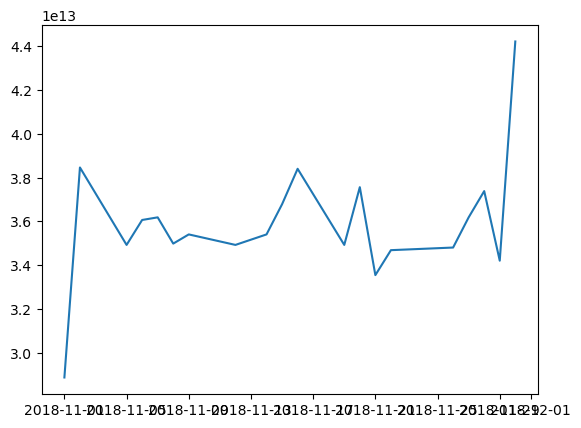

In [16]:
print("Work day = Marylebone departure in PM minus Marylebone arrival time in AM")
#print(xJourney[['Date','Day','WorkDay']][:]) 

plt.plot(xJourney['Date'] , xJourney['WorkDay']) # X-axis, Y-Axis
# plt.ylabel('Working Day')
# plt.xlabel('Date')
plt.show

* average wait time for bus home
* average office departure time
* average journey time on Tube   

In [17]:
print(dailyMean[['arriveMorden','leaveOffice','busWaitMins']])
dailyMean.drop(['DoW'], axis=1,inplace=True)
dailyMean

          arriveMorden leaveOffice  busWaitMins
Day                                            
Monday        07:49 AM    18:22 PM     3.500000
Tuesday       07:41 AM    18:38 PM     5.666667
Wednesday     07:45 AM    18:19 PM    10.200000
Thursday      07:37 AM    17:51 PM     5.600000
Friday        07:45 AM    19:24 PM     5.000000


,Date,leaveMorden,arriveOffice,leaveOffice,arriveMorden,departMorden,leaveMorden-s,arriveOffice-s,leaveOffice-s,arriveMorden-s,departMorden-s,busWait,WorkDay,busWaitMins
Day,,,,,,,,,,,,,,
Monday,2018-11-15 12:00:00,1900-01-01 07:49:45,1900-01-01 08:40:30,18:22 PM,07:49 AM,1900-01-01 19:17:15,-2.208961e+09,-2.208958e+09,-2.208923e+09,-2.208920e+09,-2.208919e+09,0 days 00:03:30,0 days 09:41:30,3.500000
Tuesday,2018-11-17 16:00:00,1900-01-01 07:41:00,1900-01-01 08:28:00,18:38 PM,07:41 AM,1900-01-01 19:32:00,-2.208961e+09,-2.208958e+09,-2.208922e+09,-2.208919e+09,-2.208918e+09,0 days 00:05:40,0 days 10:10:00,5.666667
Wednesday,2018-11-18 04:48:00,1900-01-01 07:45:24,1900-01-01 08:32:24,18:19 PM,07:45 AM,1900-01-01 19:19:48,-2.208961e+09,-2.208958e+09,-2.208923e+09,-2.208920e+09,-2.208919e+09,0 days 00:10:12,0 days 09:46:48,10.200000
Thursday,2018-11-15 00:00:00,1900-01-01 07:37:36,1900-01-01 08:26:12,17:51 PM,07:37 AM,1900-01-01 18:44:48,-2.208961e+09,-2.208958e+09,-2.208925e+09,-2.208922e+09,-2.208921e+09,0 days 00:05:36,0 days 09:25:00,5.600000
Friday,2018-11-14 06:00:00,1900-01-01 07:45:45,1900-01-01 08:32:15,19:24 PM,07:45 AM,1900-01-01 20:16:30,-2.208961e+09,-2.208958e+09,-2.208919e+09,-2.208916e+09,-2.208916e+09,0 days 00:05:00,0 days 10:52:00,5.000000


In [19]:
# print summary statistics
print('Rolling 3 day mean ', xJourney['busWaitMins'].rolling(3).mean() )
#not sure 'sum' makes sense print('Rolling 3 day sum ', xJourney['busWaitMins'].rolling(3).sum() )


Rolling 3 day mean  0           NaN
1           NaN
2      4.666667
3      3.666667
4      3.333333
5      4.000000
6     11.333333
7     11.333333
8     11.666667
9      6.000000
10     7.666667
11     5.333333
12     3.666667
13     2.000000
14     2.666667
15     3.000000
16     7.666667
17     8.333333
18     7.666667
19     4.000000
20     6.666667
Name: busWaitMins, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

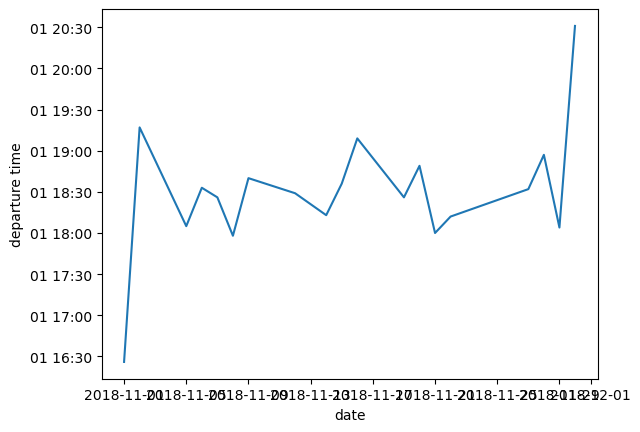

In [20]:


# ordered_df = df.sort_values(by='group',ascending=False)
plt.plot(xJourney['Date'] , xJourney['leaveOffice']) # X-axis, Y-Axis
plt.ylabel('departure time')
plt.xlabel('date')
plt.show

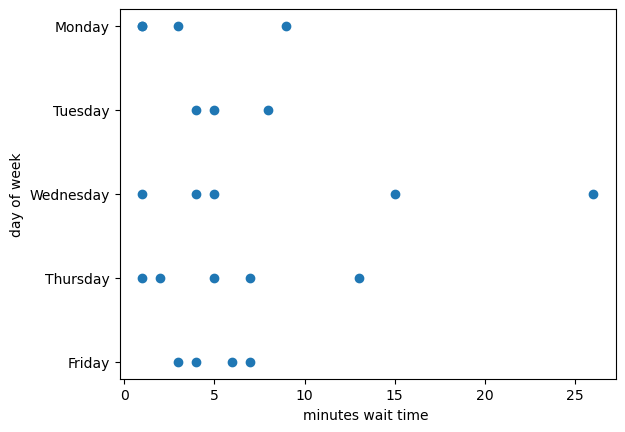

In [21]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

x = xJourney['busWaitMins']
y = xJourney['Day']

plt.ylabel('day of week')
plt.xlabel('minutes wait time ')

plt.scatter(x, y)
plt.show()

* splice different times into an array
* diff the time - wait time for a bus
* average by day of week
* average overall 
    
    
    average home time
 remove unwanted text columns.
 xJourney.drop(['Date'], axis=1,inplace=True)
    

In [ ]:
xJourney.describe(x)